In [2]:
#| default_exp datasets

In [10]:
import sys
sys.path.append('..')

In [11]:
#|export
from __future__ import annotations
import math,numpy as np,matplotlib.pyplot as plt
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc

# from torch.utils.data import default_collate
import tensorflow as tf

from miniai.training import *

In [18]:
# import logging,pickle,gzip,os,time,shutil,torch,matplotlib as mpl
import logging,pickle,gzip,os,time,shutil,matplotlib as mpl

from pathlib import Path

# from torch import tensor,nn,optim
# from torch.utils.data import DataLoader
# import torch.nn.functional as F
from datasets import load_dataset,load_dataset_builder

# import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [19]:
# torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
# torch.manual_seed(1)
tf.random.set_seed(1)
mpl.rcParams['image.cmap'] = 'gray'

In [20]:
logging.disable(logging.WARNING)

## Hugging Face Datasets

In [21]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [22]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [23]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296655, num_examples=60000, shard_lengths=None, dataset_name=None),
 'test': SplitInfo(name='test', num_bytes=5233818, num_examples=10000, shard_lengths=None, dataset_name=None)}

In [106]:
# dsd = load_dataset(name)
dsd = load_dataset(name).with_format('tf') 
dsd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

In [168]:
dsd = load_dataset(name, streaming=True)

In [174]:
train,test = dsd['train'],dsd['test']
# train[0]
next(iter(train))

{'image': <PIL.PngImagePlugin.PngImageFile image mode=L size=28x28>,
 'label': 9}

In [175]:
x,y = ds_builder.info.features

In [176]:
x,y

('image', 'label')

In [179]:
x,y = 'image','label'
# img = train[0][x]
img = next(iter(train))[x]
img

In [182]:
# xb = train[:5][x]
i_train = iter(train)
xb = [next(i_train)[x] for _ in range(5)]
# yb = train[:5][y]
i_train = iter(train)
yb = [next(i_train)[y] for _ in range(5)]
yb

[9, 0, 0, 3, 0]

In [183]:
featy = train.features[y]
featy

ClassLabel(names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)

In [184]:
featy.int2str(yb)

['Ankle boot',
 'T - shirt / top',
 'T - shirt / top',
 'Dress',
 'T - shirt / top']

In [186]:
# train['label'][:5]
i_train = iter(train)
[next(i_train)['label'] for _ in range(5)] 

[9, 0, 0, 3, 0]

In [187]:
def collate_fn(b):
    return {x:torch.stack([TF.to_tensor(o[x]) for o in b]),
            y:tensor([o[y] for o in b])}

In [188]:
train.__dict__.keys()

dict_keys(['_info', '_split', '_ex_iterable', '_formatting', '_shuffling', '_distributed', '_epoch', '_token_per_repo_id'])

In [189]:
# train[0]['image']
next(iter(train))['image']

In [195]:
class GenCallable:
    def __init__(self, ds):
        self.ds = ds
        
    def __call__(self):
        for i in self.ds: yield i

In [201]:
next(iter(dl))['label']

<tf.Tensor: shape=(), dtype=int64, numpy=9>

In [266]:
# dl = DataLoader(train, collate_fn=collate_fn, batch_size=16)

output_signature = {
    'image':tf.TensorSpec(shape=[None, None], dtype=tf.uint8),
    'label':tf.TensorSpec(shape=[], dtype=tf.int64)
}

dl = tf.data.Dataset.from_generator(GenCallable(train), output_signature=output_signature).batch(16)
b = next(iter(dl))
b[x].shape,b[y]

(TensorShape([16, 28, 28]),
 <tf.Tensor: shape=(16,), dtype=int64, numpy=array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9])>)

In [224]:
# already a tensor
def transforms(b):
    # b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [225]:
# tds = train.with_transform(transforms)
# dl = DataLoader(tds, batch_size=16)
# b = next(iter(dl))
# b[x].shape,b[y]

In [226]:
# def _transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]
def _transformi(b): b[x] = [tf.reshape(o, shape=(28*28)) for o in b[x]]
    # return b

In [227]:
#|export
def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [230]:
# can't do inplace in tf data vanilla

# transformi = inplace(_transformi)

In [231]:
# r = train.with_transform(transformi)[0]
# r[x].shape,r[y]

In [232]:
# @inplace
# def transformi(b): b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

@inplace
def transformi(b): b[x] = [tf.reshape(o, shape=(28*28)) for o in b[x]]

In [234]:
# tdsf = train.with_transform(transformi)
# r = tdsf[0]
# r[x].shape,r[y]

In [235]:
d = dict(a=1,b=2,c=3)
ig = itemgetter('a','c')
ig(d)

(1, 3)

In [236]:
class D:
    def __getitem__(self, k): return 1 if k=='a' else 2 if k=='b' else 3

In [237]:
d = D()
ig(d)

(1, 3)

In [238]:
list(tdsf.features)

['image', 'label']

In [239]:
batch = dict(a=[1],b=[2]), dict(a=[3],b=[4])
# default_collate(batch)

from cytoolz import merge_with
merge_with(tf.stack, batch)

{'a': <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[1],
        [3]], dtype=int32)>,
 'b': <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[2],
        [4]], dtype=int32)>}

In [240]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _f(b): return get(merge_with(tf.stack, b))
    return _f

In [241]:
tdsf

Dataset({
    features: ['image', 'label'],
    num_rows: 60000
})

In [251]:
def reshape_elements(d):
    d['image'] = tf.reshape(d['image'], shape=(-1,28*28))
    return d

In [256]:
# dlf = DataLoader(tdsf, batch_size=4, collate_fn=collate_dict(tdsf))
dlf = tf.data.Dataset.from_generator(GenCallable(train), output_signature=output_signature)
dlf = dlf.batch(4).map(lambda d: {
    'image':tf.reshape(d['image'], shape=(-1, 28*28)),
    'label':d['label']
})

# xb,yb = next(iter(dlf))
first = next(iter(dlf))
xb, yb = first['image'], first['label']
xb.shape,yb

(TensorShape([4, 784]),
 <tf.Tensor: shape=(4,), dtype=int64, numpy=array([9, 0, 0, 3])>)

## Plotting images

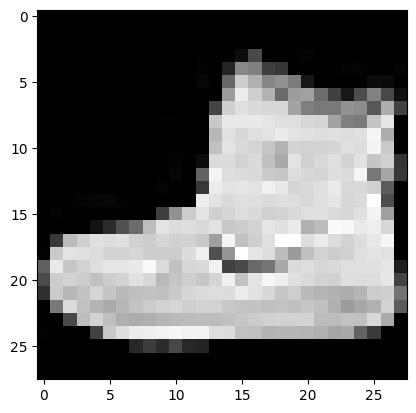

In [269]:
b = next(iter(dl))
xb = b['image']
img = xb[0]
plt.imshow(img.numpy());

In [271]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    # "Show a PIL or PyTorch image on `ax`."
    "Show a PIL or PyTorch image on `ax`."
    if fc.hasattrs(im, ('cpu','permute','detach')):
        im = im.detach().cpu()
        if len(im.shape)==3 and im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=np.array(im)
    if im.shape[-1]==1: im=im[...,0]
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([]) 
    ax.set_yticks([]) 
    if noframe: ax.axis('off')
    return ax

In [272]:
help(show_image)

Help on function show_image in module __main__:

show_image(im, ax=None, figsize=None, title=None, noframe=True, *, cmap=None, norm=None, aspect=None, interpolation=None, alpha=None, vmin=None, vmax=None, origin=None, extent=None, interpolation_stage=None, filternorm=True, filterrad=4.0, resample=None, url=None, data=None)
    Show a PIL or PyTorch image on `ax`.



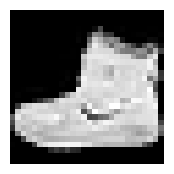

In [273]:
show_image(img, figsize=(2,2));

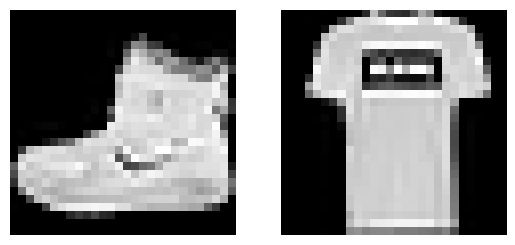

In [274]:
fig,axs = plt.subplots(1,2)
show_image(img, axs[0])
show_image(xb[1], axs[1]);

In [275]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows:int=1, # Number of rows in returned axes grid
    ncols:int=1, # Number of columns in returned axes grid
    figsize:tuple=None, # Width, height in inches of the returned figure
    imsize:int=3, # Size (in inches) of images that will be displayed in the returned figure
    suptitle:str=None, # Title to be set to returned figure
    **kwargs
): # fig and axs
    "A figure and set of subplots to display images of `imsize` inches"
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig,ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if suptitle is not None: fig.suptitle(suptitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig,ax

In [276]:
from nbdev.showdoc import show_doc

In [277]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                suptitle:str=None,
>                sharex:"bool|Literal['none','all','row','col']"=False,
>                sharey:"bool|Literal['none','all','row','col']"=False,
>                squeeze:bool=True, width_ratios:Sequence[float]|None=None,
>                height_ratios:Sequence[float]|None=None,
>                subplot_kw:dict[str,Any]|None=None,
>                gridspec_kw:dict[str,Any]|None=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

|    | **Type** | **Default** | **Details** |
| -- | -------- | ----------- | ----------- |
| nrows | int | 1 | Number of rows in returned axes grid |
| ncols | int | 1 | Number of columns in returned axes grid |
| figsize | tuple | None | Width, height in inches of the returned figure |
| imsize | int | 3 | Size (in inches) of images that will be displayed in the returned figure |
| suptitle | str | None | Title to be set to returned figure |
| sharex | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| sharey | bool \| Literal['none', 'all', 'row', 'col'] | False |  |
| squeeze | bool | True |  |
| width_ratios | Sequence[float] \| None | None |  |
| height_ratios | Sequence[float] \| None | None |  |
| subplot_kw | dict[str, Any] \| None | None |  |
| gridspec_kw | dict[str, Any] \| None | None |  |
| kwargs |  |  |  |

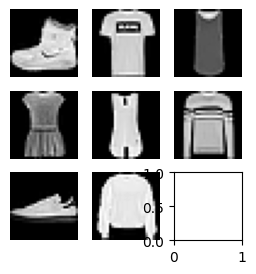

In [278]:
fig,axs = subplots(3,3, imsize=1)
imgs = xb[:8]
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [279]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int, # Number of axes
    nrows:int=None, # Number of rows, defaulting to `int(math.sqrt(n))`
    ncols:int=None, # Number of columns, defaulting to `ceil(n/rows)`
    title:str=None, # If passed, title set to the figure
    weight:str='bold', # Title font weight
    size:int=14, # Title font size
    **kwargs,
): # fig and axs
    "Return a grid of `n` axes, `rows` by `cols`"
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.floor(n/nrows))
    fig,axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig,axs

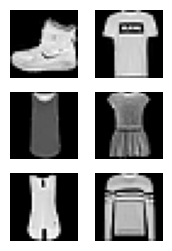

In [280]:
fig,axs = get_grid(8, nrows=3, imsize=1)
for ax,img in zip(axs.flat,imgs): show_image(img, ax)

In [281]:
#|export
@fc.delegates(subplots)
def show_images(ims:list, # Images to show
                nrows:int|None=None, # Number of rows in grid
                ncols:int|None=None, # Number of columns in grid (auto-calculated if None)
                titles:list|None=None, # Optional list of titles for each image
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im,t,ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)

In [282]:
yb = b['label']
lbls = yb[:8]

In [283]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

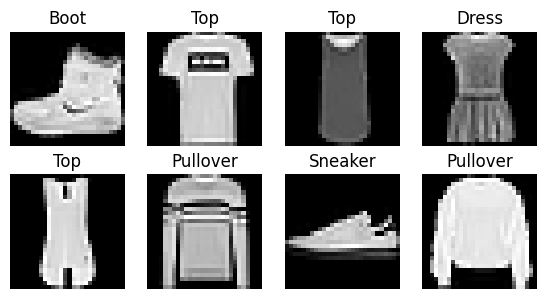

In [284]:
show_images(imgs, imsize=1.7, titles=titles)

In [285]:
# #|export
# class DataLoaders:
#     def __init__(self, *dls): self.train,self.valid = dls[:2]

#     @classmethod
#     def from_dd(cls, dd, batch_size, as_tuple=True, **kwargs):
#         f = collate_dict(dd['train'])
#         return cls(*get_dls(*dd.values(), bs=batch_size, collate_fn=f, **kwargs))

## Export -

In [286]:
import nbdev; nbdev.nbdev_export()